# Lab 3: Model Development and Evaluation

In this notebook, we are going to be focusing on building a model. In lab 2 we explored feature engineering around our research question: "What drives the loan amount requested by Kiva borrowers?"

Now, we are ready to transform our research question into a machine learning task. We will build an initial model that we will then iterate on.

In this notebook we start by getting a benchmark of performance using a linear model.

We then explore the impact on the performance when we predict using more complex algorithms:
- linear regression model
- decision tree model
- random forest model

Comparing performance across different models will help you understand the implications of model choice and how different models perform against each other.

Let's get started! We will walk though the following steps:

- split our data into train and test
- do data cleaning to fill in any null values
- test that the assumptions needed for a linear regression model hold true
- run a linear regression model
- run a decision tree model
- run a random forest model 
- compare the results of all 3 models.

## **If you haven't already, please run through Notebook 1 & 2!**  You need the final ouput df_abridged.csv.

As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1 module_1_exploratory_analysis_with_solutions, we merged these data files and created new variables to form the data frame "df_module_1", we exported it as df_module_1.csv. Then in module 2, we engineered several features and removed outliers and exported this to df_abridged.csv. We will use this dataframe now. 

First step is to import the libraries we want to use. Notice there are many sklearn libraries to import, this is a
suite of libraries that contain a range of machine learning tools. Today we are using various different sklearn packages. For more information on sklearn, check out their [diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/) for when and where to use difference machine learning methods.

In [488]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from ggplot import *
import time
import re
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

# packages for linear regression and validation 
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# the command below means that the output of multiple commands in a cell will be output at once.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)


To get more information about a new modules you have imported, run the cell below. A window containing a description of the module will appear! This provides details on the module parameters and attributes and links for further references. Try it out!

In [539]:
RandomForestRegressor?

You can do this for any module you import!

Next we import our dataset from notebook 2.

In [489]:
# Read in data
#data_path = '~/intro_course_data_science_for_good/data/'
data_path = '~/intro_to_machine_learning/data/'
df = pd.read_csv(data_path+'df_abridged.csv', low_memory=False)

The code below tells us the number of rows in our dataset, it is a good sanity check to make sure the dataframe is what is what we expect as the output of notebook 2.

In [490]:
len(df)

118199

## Preparing Our Data Set for Modeling and Final Feature Selection

Let's get out dataset ready for modeling! The first step is restricting our dataframe to the explanatory features we want to use in our model.

 Let's first take a look at what features we have after our feature engineering.

In [481]:
print(df.columns[0:120])

Index(['Unnamed: 0', 'activity', 'borrowers', 'description.texts.en',
       'funded_amount', 'funded_date', 'loan_amount', 'loan_amount.1', 'name',
       'partner_id', 'planned_expiration_date', 'posted_date', 'sector',
       'status', 'tags',
       'terms.loss_liability.currency_exchange_coverage_rate',
       'terms.repayment_term', 'terms.scheduled_payments', 'translator.byline',
       'use', 'borrower_count', 'partner_delinquency_rate',
       'partner_loans_posted', 'partner_loans_at_risk_rate',
       'partner_delinquency_rate.1', 'partner_status', 'partner_name',
       'posted_datetime', 'planned_expiration_datetime', 'dispursal_datetime',
       'posted_year', 'posted_month', 'time_to_fund', 'gender', 'kids',
       'num_tags', 'tag_#Woman Owned Biz', 'tag_#Repeat Borrower',
       'tag_#Schooling', 'parent', 'married', 'age_int', 'children_int',
       'age_bucket', 'county', 'province', 'capital', 'pct_female',
       'num_partner_countries', 'more_one_partner_country',

The code below reduces the dataframe to the feature columns we want to include, creates a copy of this df which is the **training array**, pulls out the feature that we are trying to predict and stores this as a separate **training results** array.

In [491]:
# list of features that we think may be interested to include
cols = df[['loan_amount', 
           'sector', 
           'partner_delinquency_rate',
            'posted_year',
           'posted_month',
           'gender',
           'num_tags',
           'parent',
           'tag_#Woman Owned Biz',
           'province',
           'county',
           'age_int',
           'tag_#Repeat Borrower',
           'children_int',
           'borrower_count',
            'activity',
          'more_one_partner_country',
          'days_to_fund',
          'terms.repayment_term',
           'tag_#Schooling',
           'married',
           'age_bucket',
           'capital',
           'pct_female',
           'exploratory_partner',
           'partner_dollar_amount',
           'top_partner_id',
           'num_partner_countries',
           'days_to_fund',
       'hours_to_fund',
           'top_partners'
          ]]
# create a copy of the dataframe
df_a = cols.copy()

In addition, there are some features which have a large range of possible responses. Instead of using each possible response as a features, we will just take the top 15. So example, lets look at the top activities:

In [492]:
df_a['activity'].value_counts().index[0:30]

Index(['Farming', 'Dairy', 'General Store', 'Fruits & Vegetables', 'Retail',
       'Clothing Sales', 'Agriculture', 'Poultry', 'Cereals', 'Grocery Store',
       'Tailoring', 'Motorcycle Transport', 'Food Stall', 'Charcoal Sales',
       'Beauty Salon', 'Fish Selling', 'Food Production/Sales', 'Food',
       'Used Clothing', 'Home Energy', 'Food Market', 'Livestock', 'Services',
       'Cafe', 'Primary/secondary school costs', 'Butcher Shop',
       'Animal Sales', 'Restaurant', 'Fuel/Firewood', 'Clothing'],
      dtype='object')

In [254]:
df[(df['borrower_count'] == 1)].groupby('activity')['loan_amount'].sum().nlargest(30).index[:30]

Index(['Farming', 'Dairy', 'General Store', 'Retail', 'Clothing Sales',
       'Fruits & Vegetables', 'Poultry', 'Cereals', 'Motorcycle Transport',
       'Tailoring', 'Grocery Store', 'Agriculture', 'Food Stall',
       'Beauty Salon', 'Charcoal Sales', 'Fish Selling', 'Used Clothing',
       'Food Production/Sales', 'Food', 'Services', 'Food Market', 'Livestock',
       'Butcher Shop', 'Higher education costs', 'Cafe', 'Animal Sales',
       'Renewable Energy Products', 'Restaurant',
       'Primary/secondary school costs', 'Fuel/Firewood'],
      dtype='object', name='activity')

Sklearn models can only handle boolean or numeric variables, so we will need to one-hot encode
some of the string variables that we have decided to include in our model.The following code takes the top 15 occurences for **activity, gender, province, country and sector** and creates hot coded features for both. 

What does one-hot encode mean? It means we are creating a binary explanatory feature for each category in the str. So, for example, when we one-hot encode activity we create a new column for Farming that is 1 or 0 depending on whether the loan was for a farming activity

In [493]:
cols_to_separate = ['activity','sector','county','province','gender', 'age_bucket','capital', 'top_partners']
for col in cols_to_separate:
    # Find the top ten responses
    col_vals = df.groupby(col)['loan_amount'].sum().nlargest(8).index[:8]
    for col_val in col_vals:
        # for each response, create a new feature column and assign binary responses: 1 for yes and 0 for no
        if col_val not in df_a.columns:
            df_a[col+'_'+str(col_val)] = df_a[col].apply(lambda x: 1 if x == col_val else 0)
    df_a = df_a.drop(col, axis=1)

In [484]:
print(df_a.columns)

Index(['loan_amount', 'partner_delinquency_rate', 'posted_year',
       'posted_month', 'num_tags', 'parent', 'tag_#Woman Owned Biz', 'age_int',
       'tag_#Repeat Borrower', 'children_int', 'borrower_count',
       'more_one_partner_country', 'days_to_fund', 'terms.repayment_term',
       'tag_#Schooling', 'married', 'pct_female', 'exploratory_partner',
       'partner_dollar_amount', 'top_partner_id', 'num_partner_countries',
       'days_to_fund', 'hours_to_fund', 'activity_Farming', 'activity_Dairy',
       'activity_Agriculture', 'activity_General Store', 'activity_Retail',
       'activity_Clothing Sales', 'activity_Fruits & Vegetables',
       'activity_Poultry', 'sector_Agriculture', 'sector_Food',
       'sector_Retail', 'sector_Services', 'sector_Clothing',
       'sector_Transportation', 'sector_Health', 'sector_Education',
       'county_nairobi', 'county_mombasa', 'county_bungoma', 'county_nakuru',
       'county_trans nzoia', 'county_kiambu', 'county_kisii',
       'coun

In [494]:
df_a.columns=df_a.columns.str.replace('#','')
df_a.columns=df_a.columns.str.replace(' ','_')
df_a.columns=df_a.columns.str.replace('&','')
df_a.columns=df_a.columns.str.replace(')','')
df_a.columns=df_a.columns.str.replace('(','')
df_a.columns=df_a.columns.str.replace("`",'')
df_a.columns=df_a.columns.str.replace("-",'')
df_a.columns=df_a.columns.str.replace(".",'_')

In [420]:
len(df_a.columns)

63

## Validating assumptions are held in our dataset

Our first model we will use to map the relationship between x (our explanatory features) and the true Y is a linear regression. As you may remember from the theory, a linear regression is a fairly rigid model with strong assumptions. 

Namely, the following requirements must be met:

**1) Linear relationship between x and Y**

**2) Normal distribution of variables**

**3) No autocorrelation (Independent variables)**

**4) Homoscedasticity**

**5) No multicollinearity**

**6) Rule of thumb: at least 20 observations per independent variable in the analysis**

In the section below, we check the validity of some of these assumptions before we run our model.

## Checking features for Multicollinearity

Before we get run our model, let's make sure we are not including unnecessary features. A great way to do this is using a correlation plot, because for both linear regression and decision trees we do not want to include correlated features.

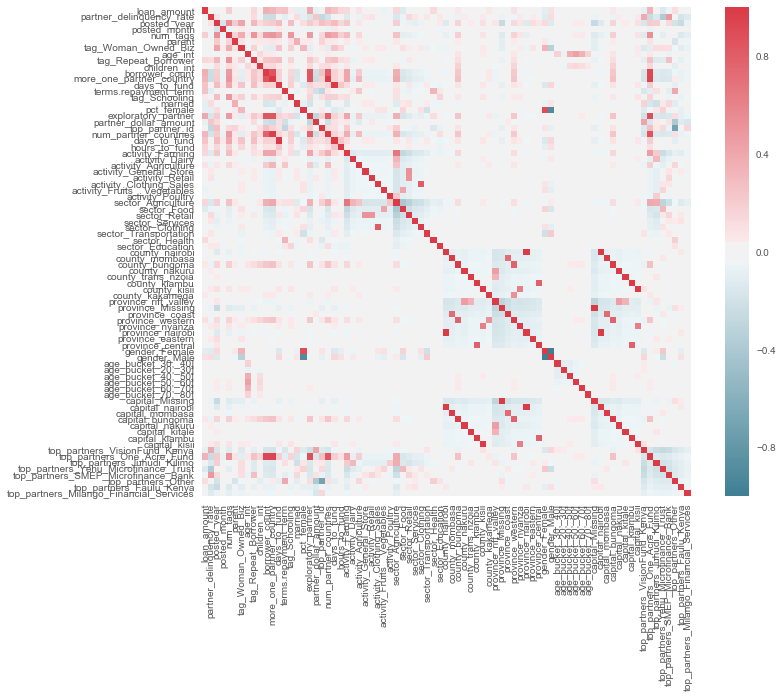

In [402]:
# Compute the correlation matrix
corrmat  = df_a.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap using seaborn
sns.heatmap(corrmat, cmap=cmap, vmax=.8, square=True)


Woah, there is a lot of information above! However, the plot also immediately tells us some features we should cut:

- gender_female and gender_male are perfectly correlated. We only need one.
- sector_agriculture and activity_farming are correlated. In fact, this is true of many of the sectors and activities, which makes sense because we are taking the top 10 for both, so any activity that makes the top 10 in loan volume will likely dominate the associated sector.
- country_kiamby and province_central are very correlated. In fact this is true of other counties and provinces, like Nairobi county and Nairobi province. We should probably only include the province feature.
- number of tags is very correlated with any given tag. This makes sense because most lenders only have one tag. We should remove this feature.


This has taught us alot!

### When we build a correlation plot we are are checking for multicollinearity!

The plot above is a way to check for multicollinearity. Multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. 

In the code below, instead of plotting the correlation matrix, we filter to only the top abs correlations that are not one. This will help us isolate the interactions that are most problematic.

In [425]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_a, 20))

Top Absolute Correlations
county_kisii              capital_kisii                 1.000000
gender_Female             gender_Male                   1.000000
county_kiambu             capital_kiambu                1.000000
province_Missing          capital_Missing               0.999975
county_bungoma            capital_bungoma               0.999916
province_nairobi          capital_nairobi               0.999894
county_trans_nzoia        capital_kitale                0.999764
county_nakuru             capital_nakuru                0.999447
county_nairobi            capital_nairobi               0.996751
                          province_nairobi              0.996644
county_mombasa            capital_mombasa               0.995928
more_one_partner_country  num_partner_countries         0.953421
                          top_partners_One_Acre_Fund    0.936224
borrower_count            top_partners_One_Acre_Fund    0.915627
pct_female                gender_Female                 0.895398

/Users/Sara/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2070: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self.loc[tuple(slicer)]
/Users/Sara/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:836: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_lowerdim(tup)


Of course, not every correlation in this list will be meaningful. This list is useful since it provides a visual shortcut to see what relationships might be problematic for multicollinearity. However, we should still use our judgement and do further validation when we see two higly correlated features whose relationship is not intuitive.

The list confirms our decision to remove county, activity and gender_male. This makes intuitive sense, let's also do soem additional exploratory analysis before we remove additional features.

#### tag_Woman_Owned_Biz correlated with posted year

Let's take a look at why the tag_Woman_Owned_Biz may be correlated with posted year. We can see in the chart below that the tag seems to be used more heavily in later years. This is probably a function of how the community of loan posters in KIVA has developed.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

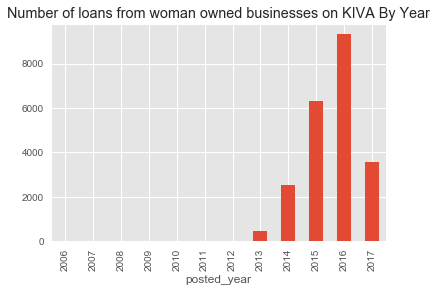

In [404]:
df_a.groupby('posted_year')['tag_Woman_Owned_Biz'].sum().plot(kind="bar", title='Number of loans from woman owned businesses on KIVA By Year')
plt.xticks(rotation=90)

In fact, we can see for the plot below of total number of tags associated with a loan by posted year that this trend is not isolated to women owned business tags. We decide to remove number of tags.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

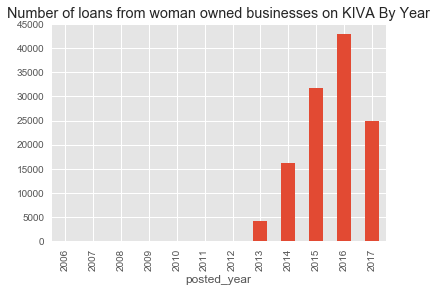

In [153]:
df_a.groupby('posted_year')['num_tags'].sum().plot(kind="bar", title='Number of loans from woman owned businesses on KIVA By Year')
plt.xticks(rotation=90)

 We will go ahead and remove activitiy, county, gender_male, number_loans_posted, more_one_partner_country, num_tags.

In [405]:
print(df_a.columns)

Index(['loan_amount', 'partner_delinquency_rate', 'posted_year',
       'posted_month', 'num_tags', 'parent', 'tag_Woman_Owned_Biz', 'age_int',
       'tag_Repeat_Borrower', 'children_int', 'borrower_count',
       'more_one_partner_country', 'days_to_fund', 'terms.repayment_term',
       'tag_Schooling', 'married', 'pct_female', 'exploratory_partner',
       'partner_dollar_amount', 'top_partner_id', 'num_partner_countries',
       'days_to_fund', 'hours_to_fund', 'activity_Farming', 'activity_Dairy',
       'activity_Agriculture', 'activity_General_Store', 'activity_Retail',
       'activity_Clothing_Sales', 'activity_Fruits__Vegetables',
       'activity_Poultry', 'sector_Agriculture', 'sector_Food',
       'sector_Retail', 'sector_Services', 'sector_Clothing',
       'sector_Transportation', 'sector_Health', 'sector_Education',
       'county_nairobi', 'county_mombasa', 'county_bungoma', 'county_nakuru',
       'county_trans_nzoia', 'county_kiambu', 'county_kisii',
       'county_k

In [495]:
df_a=df_a.drop(['gender_Male', 'province_Missing',  'activity_Farming', 'activity_Dairy', 'activity_General_Store',
       'activity_Retail', 'activity_Clothing_Sales',
       'activity_Fruits__Vegetables', 'activity_Poultry', 'activity_Cereals',
       'activity_Grocery_Store', 'activity_Tailoring', 'county_nairobi',
       'county_mombasa', 'county_nakuru', 'county_kisii', 'county_trans_nzoia',
       'county_kiambu', 'county_bungoma', 'county_kisumu', 'county_uasin',
       'county_kilifi' ], axis=1)

### Normality
In Module 3, we reviewed that normal distribution of variables is an assumption underlying linear regression. Let's look first at our outcome feature, loan_amount.

We already know our data is skewed by outliers, however before we begin modeling let's quantify the degree to which it is skewed.

[Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there are more loans in the left tail of the distribution. Typically, a skew score of +-5 is deemed acceptable.

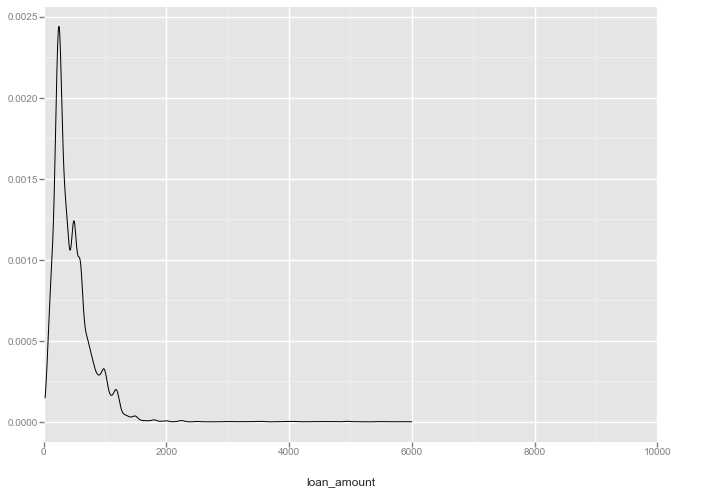

<ggplot: (-9223372036557126442)>

In [407]:
ggplot(df_a, aes(x='loan_amount')) + geom_density() + xlim(0,10000)

In [408]:
print(stats.skew(df_a.loan_amount, axis=None))

5.352856533783493


This confirms our suspicion that the data is skewed to the left. However, the degree to which it is skewed is not troubling. +-3 is fairly reasonable. In the cell below we describe a way to address this if you face a dataset with more severely skewed data.

## Additional context on how to deal with skewed data:


One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = a + bx 

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. 

Our interpretation of the regression depends upon what side of the equation we log transform:

**log-level (transform the outcome variable):**

Now we have a log equation: 

    log(y) = a + bx
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. 

The model log(y) = mx + b is called a log-level equation because only the left hand side of the equation (the outcome variable) is logged. The interpretation is:

“if we change x by 1 (unit), we’d expect our y variable to change by 100⋅β1 percent”


**log-log (transform the outcome and the explanatory variable):**

**What about if we need to log transform both sides of the data?**

Often, we need to address skewed data in both the outcome variable and the explanatory features. This results in what we call a log-log model because both sides of the equation are logged.

log(y) = a + blog(x)

The interpretation of a log-log model is:

“if we change x by one percent, we’d expect y to change by β1 percent”

[This](http://www.cazaar.com/ta/econ113/interpreting-beta) website is a very thorough coverage of how to interpret your parameter b, after transforming the data through logging.

##  Final feature selection

In [500]:
# final feature list
cols = df_a[['loan_amount', 'partner_delinquency_rate', 'posted_year',
       'posted_month', 'parent',
       'tag_Repeat_Borrower', 'children_int', 'borrower_count', 'more_one_partner_country',
       'terms_repayment_term', 'tag_Schooling', 'married', 'pct_female','exploratory_partner',
      'sector_Agriculture', 'sector_Food', 'tag_Woman_Owned_Biz',
       'sector_Retail', 'sector_Services', 'sector_Clothing',
       'sector_Transportation', 'sector_Health', 'sector_Education', 'age_int', 'capital_nairobi', 'capital_mombasa', 'capital_bungoma',
       'capital_nakuru', 'capital_kitale', 'capital_kiambu', 'capital_kisii', 'top_partners_VisionFund_Kenya',
      'top_partners_One_Acre_Fund',
       'top_partners_Juhudi_Kilimo', 'top_partners_Yehu_Microfinance_Trust',
       'top_partners_SMEP_Microfinance_Bank', 'top_partners_Other',
       'top_partners_Faulu_Kenya', 'top_partners_Milango_Financial_Services']]
# create a copy of the dataframe
rf_trainArr = cols.copy()
rf_trainArr=rf_trainArr[rf_trainArr['posted_year']>2009]

## Checking for null values

In [497]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print (rf_trainArr.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

#Applying per row:
print ("\nMissing values per row:")
print (rf_trainArr.apply(num_missing, axis=1).head()) #axis=1 defines that function is to be applied on each row

Missing values per column:
loan_amount                                0
partner_delinquency_rate                   0
posted_year                                0
posted_month                               0
parent                                     0
tag_Repeat_Borrower                        0
children_int                               0
borrower_count                             0
more_one_partner_country                   0
terms_repayment_term                       0
tag_Schooling                              0
married                                    0
pct_female                                 0
exploratory_partner                        0
sector_Agriculture                         0
sector_Food                                0
tag_Woman_Owned_Biz                        0
sector_Retail                              0
sector_Services                            0
sector_Clothing                            0
sector_Transportation                      0
sector_Health               

There are no nulls! We did a good job in the prior notebook filling out all most of the explanatory fields with priors. If you did have nulls, the commented out code below would drop these rows. However, be aware that if you have many nulls in one field you should rather go back and fill with a good prior than lose many rows of valuable data. 

In [430]:
###rf_trainArr = rf_trainArr.dropna()

## Splitting into train and test

To understand how well our model generalizes, we need to split our data into a test and training set. In order to get a true prediction, we can't show our model the test labels. Instead we just ask the model to score based upon the test explanatory variables.

In order to get to this, we split the dataframe into a test and train.

### train and test dataset

## X_train, y_train, X_test, y_test

However, we additionally need to seperate the explanatory features from our outcome feature.

To do this we need to create four subsets of data:
- X_train: the explanatory features to train the algorithm
- y_train: the outcome feature associated with the training features - In this case, these are the loan amounts
- X_test: the explanatory features to test the algorithm
- y_test: the true Y of the target features associated with the testing geatures - again, in this case, these are the loan amounts

To do this we will use the sklearn model selection function **train_test_split**. If you look back to the top of this page, we imported this function at the beginning of the notebook.

The names used below (X_train, X_test, y_train, y_test) are the conventions used in industry for train and test data so you will continue to see them repeatedly.

In [502]:
print(rf_trainArr.columns)

Index(['loan_amount', 'partner_delinquency_rate', 'posted_year',
       'posted_month', 'parent', 'tag_Repeat_Borrower', 'children_int',
       'borrower_count', 'more_one_partner_country', 'terms_repayment_term',
       'tag_Schooling', 'married', 'pct_female', 'exploratory_partner',
       'sector_Agriculture', 'sector_Food', 'tag_Woman_Owned_Biz',
       'sector_Retail', 'sector_Services', 'sector_Clothing',
       'sector_Transportation', 'sector_Health', 'sector_Education', 'age_int',
       'capital_nairobi', 'capital_mombasa', 'capital_bungoma',
       'capital_nakuru', 'capital_kitale', 'capital_kiambu', 'capital_kisii',
       'top_partners_VisionFund_Kenya', 'top_partners_One_Acre_Fund',
       'top_partners_Juhudi_Kilimo', 'top_partners_Yehu_Microfinance_Trust',
       'top_partners_SMEP_Microfinance_Bank', 'top_partners_Other',
       'top_partners_Faulu_Kenya', 'top_partners_Milango_Financial_Services'],
      dtype='object')


Our OLS package only requires the training data is split into train & test.

In [430]:
train, test = train_test_split(rf_trainArr, test_size=0.2, random_state=42)
len(train)
len(test)

90744

22687

Our scikit learn package requires that the explanatory variables are stored seperately from the outcome variables.

In [431]:
# create a training array = all the features but not the target and a training test array = the results of the target variable for the training array
rf_trainY = rf_trainArr['loan_amount']
rf_trainX = rf_trainArr.drop('loan_amount', axis=1)

In [432]:
X_train, X_test, y_train, y_test = train_test_split(rf_trainX, rf_trainY, test_size=0.2, random_state=42)

len(X_train)
len(X_test)
len(y_train)
len(y_test)

90744

22687

90744

22687

# Linear Regression

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function since the output is more intuitive. Let's try a simple example to start: 

In [417]:
model0 = sm.ols(formula="loan_amount ~ pct_female", data=train).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     628.4
Date:                Sun, 11 Jun 2017   Prob (F-statistic):          3.29e-138
Time:                        08:40:51   Log-Likelihood:            -6.7563e+05
No. Observations:               90744   AIC:                         1.351e+06
Df Residuals:                   90742   BIC:                         1.351e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    526.6208      2.367    222.498      0.0

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*pct_female

Therefore, these results can be translated as follows: 

    loan_amount = 525.29 -0.79*(pct_female)
    
Let's state the results. Regardless of gender the predicted loan amount is 526 dollars. However, if the lender group or individual is 100% female the loan amount decreases by 79 dollars. This is consistent with our earlier explanatory analysis. How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 


## Multivariate Regression

In [434]:
print(train.columns)

Index(['loan_amount', 'partner_delinquency_rate', 'posted_year',
       'posted_month', 'parent', 'tag_Repeat_Borrower', 'children_int',
       'borrower_count', 'more_one_partner_country', 'terms_repayment_term',
       'tag_Schooling', 'married', 'pct_female', 'exploratory_partner',
       'sector_Agriculture', 'sector_Food', 'tag_Woman_Owned_Biz',
       'sector_Retail', 'sector_Services', 'sector_Clothing',
       'sector_Transportation', 'sector_Health', 'sector_Education', 'age_int',
       'capital_nairobi', 'capital_mombasa', 'capital_bungoma',
       'capital_nakuru', 'capital_kitale', 'capital_kiambu', 'capital_kisii',
       'top_partners_VisionFund_Kenya', 'top_partners_One_Acre_Fund',
       'top_partners_Juhudi_Kilimo', 'top_partners_Yehu_Microfinance_Trust',
       'top_partners_SMEP_Microfinance_Bank', 'top_partners_Other',
       'top_partners_Faulu_Kenya', 'top_partners_Milango_Financial_Services'],
      dtype='object')


In [503]:
model1 = sm.ols(formula="loan_amount~ partner_delinquency_rate+ posted_year+posted_month+ \
parent + tag_Repeat_Borrower + children_int  + borrower_count + more_one_partner_country + terms_repayment_term + \
tag_Schooling + married + pct_female + exploratory_partner + tag_Woman_Owned_Biz + \
sector_Agriculture + sector_Food + sector_Retail + sector_Services + sector_Clothing +  +\
sector_Transportation + sector_Education + sector_Health + capital_nairobi +\
capital_mombasa + capital_bungoma + capital_kisii + capital_kitale + capital_kiambu + top_partners_VisionFund_Kenya + \
top_partners_One_Acre_Fund + top_partners_Juhudi_Kilimo + top_partners_Yehu_Microfinance_Trust + top_partners_SMEP_Microfinance_Bank + \
top_partners_Faulu_Kenya + top_partners_Milango_Financial_Services", data=train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     1086.
Date:                Mon, 12 Jun 2017   Prob (F-statistic):               0.00
Time:                        14:34:28   Log-Likelihood:            -6.6007e+05
No. Observations:               90744   AIC:                         1.320e+06
Df Residuals:                   90708   BIC:                         1.321e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [436]:
print ("GFT + Wiki / GT  R-squared", model1.rsquared)

GFT + Wiki / GT  R-squared 0.295259759964


## Analyzing the output of our multivariate regression

### R2

Note that the Adjusted R Squared in our multivariate regressionis extremely low. 

The Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of these combination of variables is pretty low in  predicting loan_amount. 


**So what do we do next? A low adjusted R2 can mean a few different things:**

- we need better feature engineering (let's look at our p-values do understand better what is driving the current explanatory power of the model)
- we need more data (we do have a lot of data so this is probably not the reason)
- do better feature selection (we are throwing too many useless features at our model)
- we need a more sophistocated model (we can check this by comparing the performance of a more complex model on the same features... we will do this later in this notebook by trying the same model with a decision tree)


### P Values, Statistical Significance

Remember that we want each features importance to fall within the 95% confidence interval, or the p-value to be <= 0.05. In the multivariate regression above, most of our features are important! However, there are a few that are not:

- province_eastern  
- sector_Agriculture 
- children_int 
- sector_Retail 
- province_eastern 
- province_nairobi
- province_coast 

Let's not remove them immediately, but keep this in mind for when we do additional feature selection.

### Now let's see how our multivariate linear model scores unseen (test) data.

In the cell below we use the parameters we trained using our training data to score our unseen test data.

In [504]:
predicted_y=model0.predict(test)

We are able to generate some exciting new metrics using our test_set that we created earlier on in the code. First, let's take a look at the predicted value of y, and the true y.  

In [505]:
#Let's calculate the difference! 
y_diff = abs(y_test - predicted_y)
y_diff[:1]

77455    3.23602
dtype: float64

This is interesting, but the absolute value of the difference between predicted and true Y doesn't tell us too much on its own. However, it is used as an input in calculating many statistical measures of fit. Let's take a look: 

[Mean Absolute Error](https://www.kaggle.com/wiki/MeanAbsoluteError)

The mean absolute error is calculated as the mean of the distance between predicted and true Y. We take the absolute value of (predicted Y - true Y) so we capture the concept of distance for each observation. Then we take the mean over all observations to get a sense of the entire model. The closer the final statistic is to 0, the better.

In [506]:
print("Mean absolute error: %.2f"
     % np.mean(y_diff))

Mean absolute error: 250.34


[Root Mean Squared Error](https://www.kaggle.com/wiki/RootMeanSquaredError)

The root mean squared error is calculated as the square root of the mean of the difference between predicted and true Y squared. This is a little more complicated to interpret than the MAE, but a useful indication of fit. Like the MAE, the closer this final statistic is to 0, the better.  

We use both RMSE and MAE in practice. See [this blog post](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d) for a discussion of the difference between the two metrics.

Firstly, we calculate mean squared error. The closer to 0 the better. While MSE and RMSE are equally intuitive, RMSE is more intuitive to interprete because it is in the units of our outcome variable.

In [440]:
print("Mean squared error: %.2f"
      % (np.mean((y_diff) ** 2)))

Mean squared error: 170857.42


In [441]:
print("Root mean squared error: %.2f"
      % np.sqrt(np.mean((y_diff) ** 2)))

Root mean squared error: 413.35


### R2

Unfortunately, STATSModel has no easy way to produce the adjusted R2 of our test set. So, we instead turn to another scikit learn package.

In [507]:
# Linear Regression

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
model1 = regr.fit(X_train, y_train)
print(model1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [508]:
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
linear_training_score = model1.score(X_train, y_train)
linear_testing_score = model1.score(X_test, y_test)
print("Train score: " + str(linear_training_score))
print("Test score: " + str(linear_testing_score))

Train score: 0.295510124251
Test score: 0.292406756155


Or we can use cross validation by leveraging the code below. This means we no longer have need for a test set.

In [509]:
# Create linear regression object
regr = linear_model.LinearRegression()

scores = cross_val_score(regr, rf_trainX, rf_trainY, cv=10, scoring='r2')
print(scores)

[-0.0172196   0.27222533  0.11498113  0.50028189  0.10783599 -0.07947569
  0.25176915  0.09847907  0.13996535 -0.15205961]


### What is this comparison between train and test telling this?

Both the train and test score are low. This means we are not overfitting, and confirms our suspicion that we may be underfitting. Our model is not great at explaining loan_score, we suspect this is because a linear model does not fit this data well. We can also plot out the train and test predictions against the actual.

### Training dataset: Plotting Predicted Against Actual

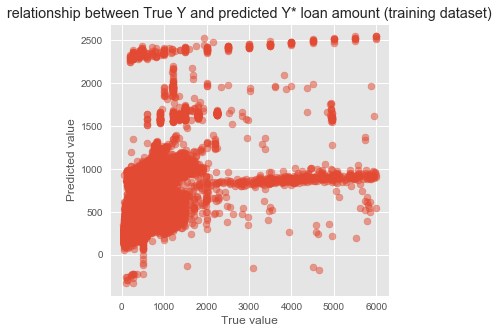

In [510]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
linear_y_predicted_train = model1.predict(X_train)
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_train, linear_y_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (training dataset)")
plt.show()

### Test dataset: Plotting Predicted Against Actual

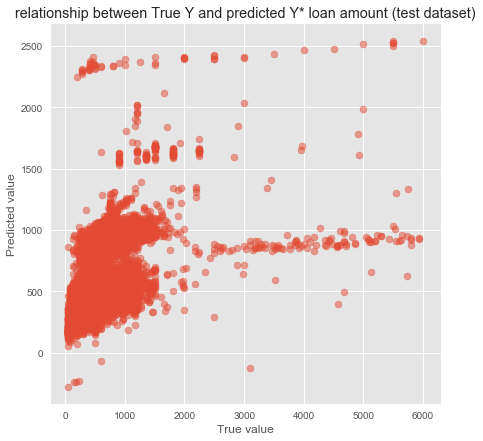

In [511]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
linear_y_predicted_test = model1.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, linear_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (test dataset)")
plt.show()

## Decision Tree and Random Forest


As you learned in the class, decision trees can be used to predict and classify data features. To improve on the simple decision tree, we can use ensemble methods such as Bagging and Random Forest. In an Ensemble approach, the algorithm acts as a group of experts analysing your data and the results is the aggregation of those individual analyses. 

A quick refresher on Bagging
- Grow multiple decisions of random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!


Now we will compare linear regressions to decision trees and random forest. We will use the same features and will be predicting the same outcome feature loan_amount.

** we will be looking at how we can predict the loan amount using decision trees, bagged decisions trees and the random forest algorithm.**

However, it is worth mentioning that these methods can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very simple example of how the RandomForestClassifier works: https://bicorner.com/2015/10/26/random-forest-using-ipython/

One of the advantages of the RandomForest algorithms is that we can pass through a whole range of features, regardless of whether we believe there is a linear relationship between the target (loan amount) and the feature and then find out which features have the highest influence. Remember from the course notes, the RandomForest Algorithms are based on the concept of decision trees where the set of all possible values are split into non-overlapping groups. 

This can be really powerful tool as it requires less initial investigation and analysis than a regression analysis.

Step by Step approach to modeling:

For the following methods used, there is some standard steps used to implement the algorithms. A simple overvew of these steps are:
- **Step 1: Initiate the algorithm** This is where we define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, this is where we would define the maximum depth, the minimum samples in a leaf etc. To learn more about the parameters for each algorithm, either check the module documentation on the internet or run a cell with the algorithm name followed by ? as we did at the beginning of this notebook for the RandomForestRegressor. These resources will also tell you the default values used for each parameter. 
- **Step 2: Train the algorithm** This is where we train the algorithm by fitting it to the X_train and y_train datasets. 
- **Step 3: Evaluating the algorithm** This is where we evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

Let's start with **loan amount** and see if we can predict how much is requested to be funded using the decision trees and ensemble methods! 

### Decision Tree
Before we get into some of the more sophisticated models, let's first try an individual Decision Tree and see how it performs.  After training the model, we will be able to assess it's performance by using sklearns useful method .score, which calculates the r2 value for the data provided.  We will first print out the r2 score for the training data, and then will print out the r2 score for the test data.

In [512]:
from sklearn.tree import DecisionTreeRegressor
# Step 1: Initiating the DecisionTreeRegressor algorithm
decision_regressor = DecisionTreeRegressor(random_state=0)
# Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
decision_regressor.fit(X_train, y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
dt_training_score = decision_regressor.score(X_train, y_train)
dt_testing_score = decision_regressor.score(X_test, y_test)
print("Train score: " + str(dt_training_score))
print("Test score: " + str(dt_testing_score))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

Train score: 0.989259390205
Test score: 0.528351544962


From the scores above (the R^2 of the regression between true and predicted loan amounts), we can see that the decision tree works very well on the training dataset, as expected. However, when applied to the testing dataset, it performs much worse. 

The R^2 number above are pretty telling but it is always nice to visualise how these look in a scattor plot. This allows us to visualise the variation between the predicted loan amount and the true loan amount values. 

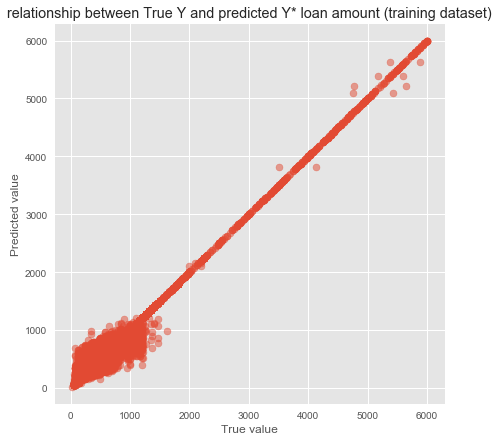

In [513]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
dt_y_predicted_train = decision_regressor.predict(X_train)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_train, dt_y_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (training dataset)")
plt.show()

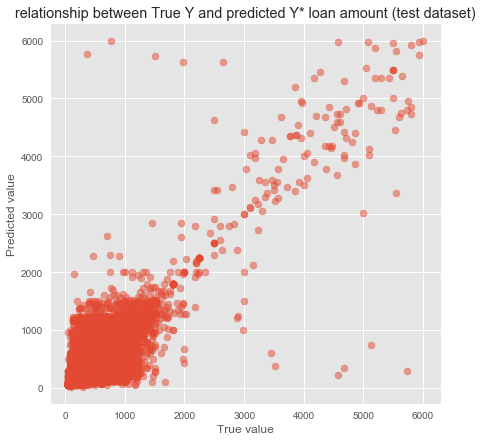

In [514]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
dt_y_predicted_test = decision_regressor.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, dt_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (test dataset)")
plt.show()

The decison tree regressor is near perfect on the training data; however, much worse on the test data.  This is largely due to the likelihood an individual trees  of overfitting to the data. Remember overfitting can occur when the tree goes too deep, the minimum leaf sample if too small or the maximum number number of terminal nodes is too high. We can mitigate the impact of overfitting by tuning and optimising these hyperparameters. However, often it is very time consuming and difficult to find the optimal hyperparameters and therefore we look towards ensemble approaches for an easier, more general solution. 

## Bagging

Another approach to overcome this is to build a collection of trees with sklearn's BaggingRegressor.  A bagging regressor builds some specified number of trees and trains each tree with a random subset of the data and then averages the forecast of each individual tree. 

This is an **Ensemble approach** where we use the results of several random analyses to find an average response. For each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or oob_score). This score calculates the error rate of the predictions on the sample not used while training an individual tree. (Remember a random ~2/3 of data are used to train a given tree).

In [515]:
from sklearn.ensemble import BaggingRegressor
# Step 1: Initiating the bagging regressor algorithm
bagging_regressor = BaggingRegressor(oob_score=True)
# Step 2: Training the bagging regressor algorithm
bagging_regressor.fit(X_train, y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
br_training_score = bagging_regressor.score(X_train, y_train)
br_testing_score = bagging_regressor.score(X_test, y_test)
br_oob_score = bagging_regressor.oob_score_
print("Train score: " + str(br_training_score))
print("Test score: " + str(br_testing_score))
print("Oob score: " + str(br_oob_score))

/Users/Sara/anaconda/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:986: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.941757429521
Test score: 0.728774329377
Oob score: 0.639112286903


The results above show that the train R^2 score has reduced but the test R^2 score has increased. This is a good sign as it means that the algorithm is overfitting the training less and therefore improving its ability to predict the loan amounts on unseen samples. 

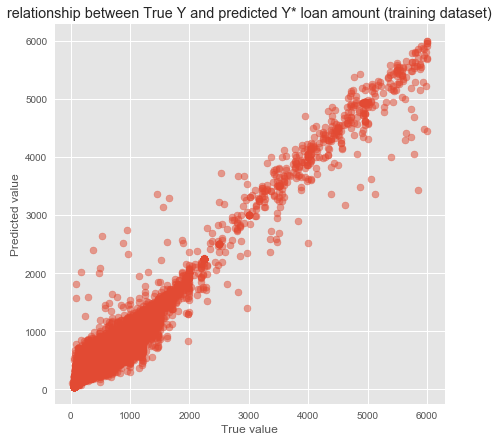

In [516]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
br_predicted_train = bagging_regressor.predict(X_train)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_train, br_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (training dataset)")
plt.show()

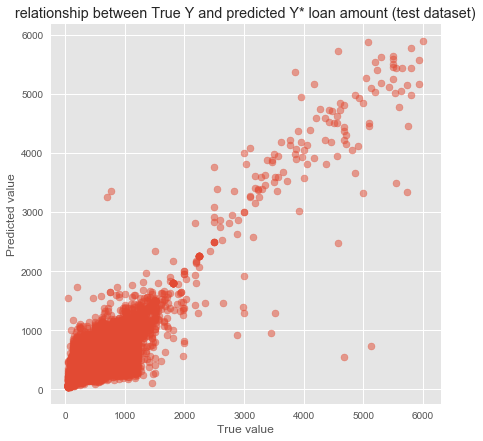

In [517]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
br_predicted_test = bagging_regressor.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, br_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (test dataset)")
plt.show()

When comparing the different regression models, we will be looking at three main outputs:
- Train score = R^2 between the predicted and true values for the training dataset
- Test score = R^2 between the predicted and true values for the test dataset
- Oob_score = the error rate of predicted values for data not used whilst training an individual tree

Therefore, we are defining a function below that prints out these score's us

In [518]:
# Since we will evaluate a few models, let's define a function that prints out the scores we care about
def print_scores(regressor, X_train, y_train, X_test, y_test, oob_score=True):
    print("Train score: " + str(regressor.score(X_train, y_train)))
    print("Test score: " + str(regressor.score(X_test, y_test)))
    print("OOB score: " + str(regressor.oob_score_))

### Changing some model parameters

The default number of trees used in the bagging regressor is 10. This means that the algorithms splits the dataset into 10 different tress, trains each one individually, predicts the result from each one individually and then averages the result. 

Let's see how performance changes when we increase the number of trees from 10 to 100.

In [454]:
# Step 1: Initiating the bagging regressor algorithm
bagging_regressor = BaggingRegressor(n_estimators=100, oob_score=True)
# Step 2: Training the bagging regressor algorithm
bagging_regressor.fit(X_train, y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores(bagging_regressor, X_train, y_train, X_test, y_test, oob_score=True)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.9552670398
Test score: 0.743851791923
OOB score: 0.731403639759


Here we see an improvement in all score and in particular the oob_score. This is telling us that splitting the dataset into more tree leads to a more accurate average predicton of the loan_amount. 

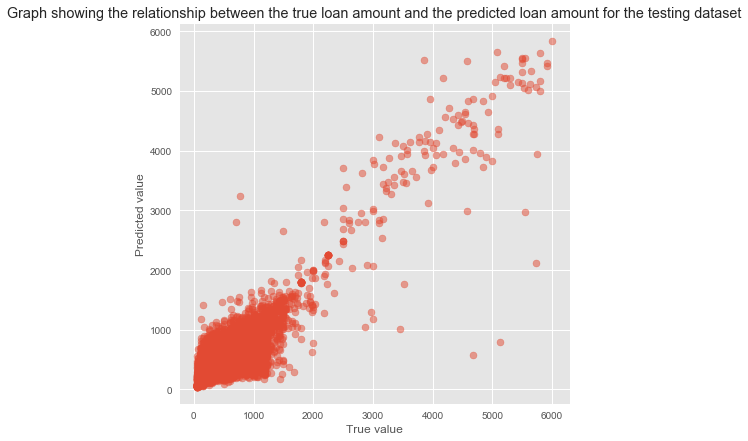

In [455]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
br_y_predicted_test = bagging_regressor.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, br_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the testing dataset")
plt.show()

## Random Forest
We still observe a large discrepancy between the training data and the test data.  This is largely because the decision trees are largely correlated, meaning that Subsets of the same data are probably going to split on the same features and result in very similar predictions.

To de-correlate the trees, we can use a Random Forest Regressor, which only considers a random subsample of the features at each split.

In [519]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=100, oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(X_train,y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores(rf_regressor, X_train, y_train, X_test, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.95536713458
Test score: 0.745742484071
OOB score: 0.73013825649


We can see that the random forest algorithm has improved the generalization performance relative to the bagging regressor. This indicates that the features we are using are already highly uncorrelated.

Mean squared error between the predicted and true loan amounts: 7713 


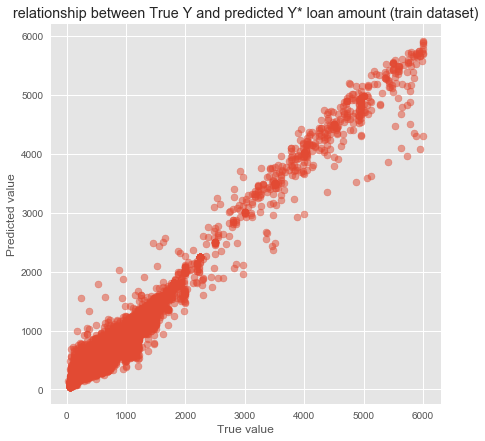

In [520]:
rf_y_predicted_train = rf_regressor.predict(X_train)
print("Mean squared error between the predicted and true loan amounts: %d " % round(mean_squared_error(y_train, rf_y_predicted_train)))

fig = plt.figure(figsize=(7, 7))
plt.scatter(y_train, rf_y_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (train dataset)")
plt.show()

Mean squared error between the predicted and true loan amounts: 43922 


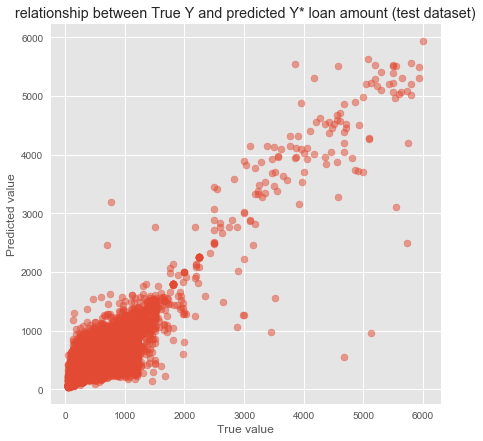

In [458]:
rf_y_predicted_test = rf_regressor.predict(X_test)
print("Mean squared error between the predicted and true loan amounts: %d " % round(mean_squared_error(y_test, rf_y_predicted_test)))

fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, rf_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (test dataset)")
plt.show()

## Further Hyperparameter Tuning

Since, we are relying of OOB score we do not in fact need to have a seperate test set. We can use our full dataset for training with a small subset held to the side for each model to comput the OOB score. 

In [459]:
# Since we will evaluate a few models, let's define a function that prints out the scores we care about
def print_scores_full(regressor, rf_trainX,rf_trainY , oob_score=True):
    print("Train score: " + str(regressor.score(rf_trainX, rf_trainY)))
    print("OOB score: " + str(regressor.oob_score_))

We also increase the number of estimators in our model to 400 and set the min_samples_leaft to 20 to improve upon overfitting.

In [460]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=400, random_state=42, min_samples_leaf=20,oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(rf_trainX,rf_trainY)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores_full(rf_regressor, rf_trainX,rf_trainY , oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

Train score: 0.757759947568
OOB score: 0.726812276041


Recall that the difference between the Bagging Regressor and the RandomForest is that in the RandomForest, at each split, a random subset of features is considered. The reducing the chance of correlation between the different trees. 

Now, let's try to figure out which features are driving our model's predictions.  Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature.

In [521]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, rf_trainX.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature borrower_count (0.250391)
2. feature posted_year (0.161943)
3. feature posted_month (0.111225)
4. feature terms_repayment_term (0.104476)
5. feature more_one_partner_country (0.046325)
6. feature age_int (0.042060)
7. feature married (0.035713)
8. feature partner_delinquency_rate (0.035550)
9. feature children_int (0.029197)
10. feature top_partners_One_Acre_Fund (0.027143)
11. feature pct_female (0.017862)
12. feature sector_Retail (0.014358)
13. feature sector_Agriculture (0.011253)
14. feature parent (0.009929)
15. feature top_partners_Yehu_Microfinance_Trust (0.007855)
16. feature top_partners_Other (0.007043)
17. feature tag_Repeat_Borrower (0.006609)
18. feature capital_nairobi (0.005734)
19. feature capital_mombasa (0.005716)
20. feature sector_Education (0.005663)
21. feature capital_nakuru (0.005318)
22. feature sector_Health (0.004985)
23. feature top_partners_VisionFund_Kenya (0.004980)
24. feature tag_Woman_Owned_Biz (0.004556)
25. feature tag_Sc

<Container object of 38 artists>

([<matplotlib.axis.XTick at 0x125304828>,
 <a list of 38 Text xticklabel objects>)

(-1, 38)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]), <a list of 38 Text xticklabel objects>)

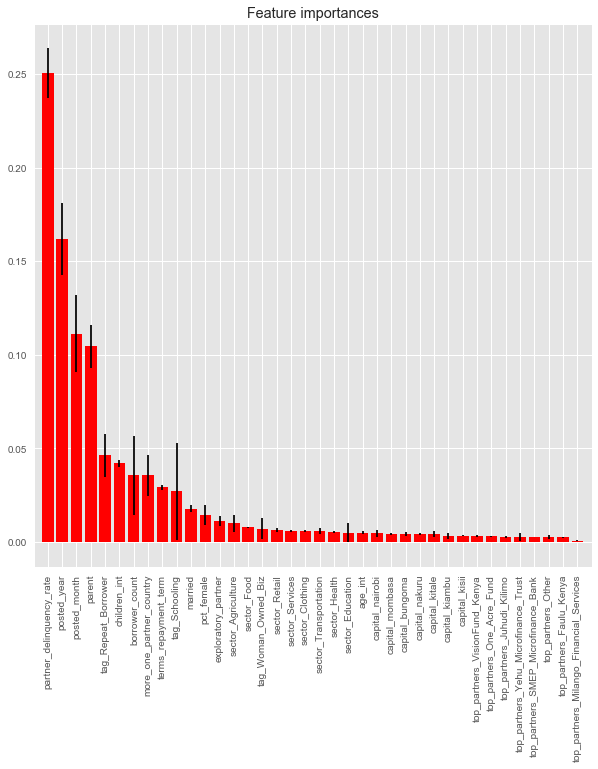

In [536]:
importances = rf_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_names = rf_trainX.columns 
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(rf_trainX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(rf_trainX.shape[1]),feature_names)
plt.xlim([-1, rf_trainX.shape[1]])
plt.xticks(rotation=90)
plt.show()

plt.savefig('module_3_images/feature_importance.png')

What is interesting here is that there is not a very clear relationship between any single feature and the loan_amount. However the aggregat these features together into either the bagged regressor or the random forest algorithm leads to very effective predictions (R^2 ~ 0.74). This is a testament to the predictive power of decisions trees and ensemble methods!

Let's try taking the top 20 features and observe it's impact on performance

In [537]:
relevant_cols = [rf_trainX.columns[indices[f]] for f in range(20)]
X_train2 = rf_trainX[relevant_cols]

In [538]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=400, random_state=42, min_samples_leaf=20,oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(X_train2,rf_trainY)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores_full(rf_regressor, X_train2,rf_trainY, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

Train score: 0.751521308997
OOB score: 0.721850423036


In [543]:
X_train, X_test, y_train, y_test = train_test_split(X_train2, rf_trainY, test_size=0.2, random_state=42)

len(X_train)
len(X_test)
len(y_train)
len(y_test)

90744

22687

90744

22687

In [546]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=400, random_state=42, min_samples_leaf=20,oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(X_train,y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores(rf_regressor, X_train, y_train, X_test, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

Train score: 0.738805595555
Test score: 0.725433941473
OOB score: 0.707024728515


Mean squared error between the predicted and true loan amounts: 45138 


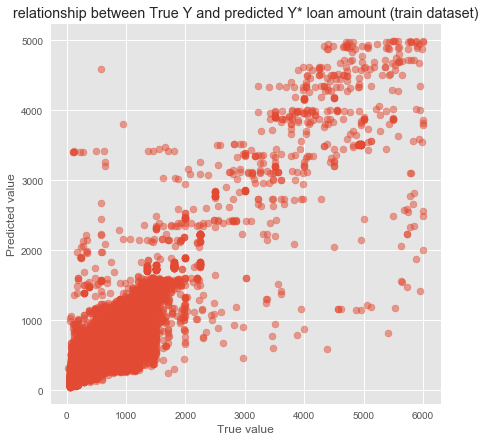

In [549]:
rf_y_predicted_train = rf_regressor.predict(X_train)
print("Mean squared error between the predicted and true loan amounts: %d " % round(mean_squared_error(y_train, rf_y_predicted_train)))

fig = plt.figure(figsize=(7, 7))
plt.scatter(y_train, rf_y_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (train dataset)")
plt.show()

Mean squared error between the predicted and true loan amounts: 47255 


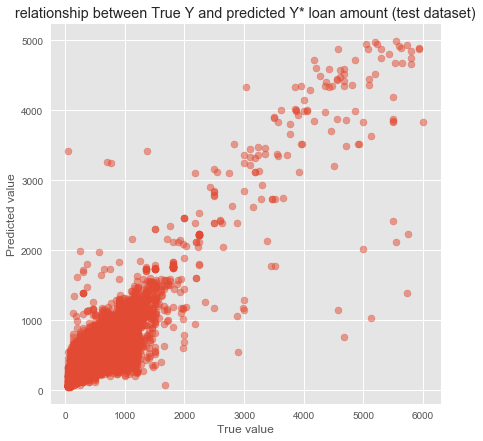

In [548]:
rf_y_predicted_test = rf_regressor.predict(X_test)
print("Mean squared error between the predicted and true loan amounts: %d " % round(mean_squared_error(y_test, rf_y_predicted_test)))

fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, rf_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("relationship between True Y and predicted Y* loan amount (test dataset)")
plt.show()

The scores haven't changed significantly which means that we can continue just using the top 20 features. This means the algorithms is much faster and gives us a clearer idea of which features affect the loan amount

In [472]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, X_train2.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature borrower_count (0.320873)
2. feature posted_year (0.191886)
3. feature terms_repayment_term (0.130257)
4. feature posted_month (0.105737)
5. feature more_one_partner_country (0.059595)
6. feature married (0.046283)
7. feature partner_delinquency_rate (0.031012)
8. feature top_partners_One_Acre_Fund (0.030844)
9. feature sector_Agriculture (0.011631)
10. feature top_partners_Yehu_Microfinance_Trust (0.010544)
11. feature pct_female (0.007960)
12. feature sector_Education (0.007060)
13. feature parent (0.007056)
14. feature tag_Repeat_Borrower (0.006592)
15. feature age_int (0.006199)
16. feature children_int (0.006145)
17. feature top_partners_VisionFund_Kenya (0.005884)
18. feature top_partners_SMEP_Microfinance_Bank (0.005069)
19. feature top_partners_Other (0.005030)
20. feature top_partners_Juhudi_Kilimo (0.004345)


<Container object of 20 artists>

([<matplotlib.axis.XTick at 0x14b103a20>,
 <a list of 20 Text xticklabel objects>)

(-1, 20)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

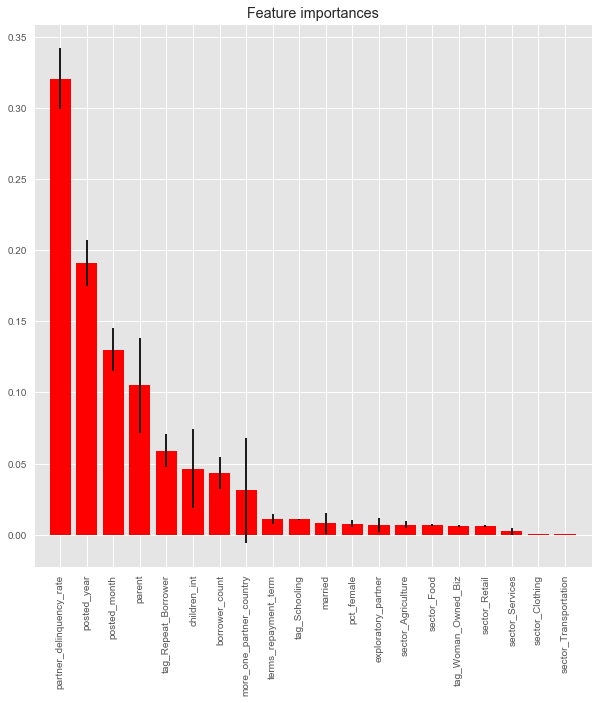

In [541]:
importances = rf_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_names = rf_trainX.columns 
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X_train2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train2.shape[1]),feature_names)
plt.xlim([-1, X_train2.shape[1]])
plt.xticks(rotation=90)
plt.show()

plt.savefig('module_3_images/feature_importance.png')

Before we move onto homework, remember to output your final dataframe so you don't have to rerun it.

In [473]:
df.to_csv(data_path+'df_module_3.csv')

## Predicting Days to Fund

Repeat the BaggingRegressor and the RandomForestRegressor method with a new target feature: days_to_fund. Determine the monst important features and discuss which features are intuitive or a surprise and why. 


In [147]:
# adding the loan_amount feature back into the rf_trainArr dataset
rf_trainArr['loan_amount'] = rf_trainRes
# The new target feature result is the days_to_fund so pull that out and drop it from the training array
rf_trainRes = rf_trainArr['days_to_fund']
rf_trainArr = rf_trainArr.drop('days_to_fund', axis=1)

In [ ]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

In [ ]:
# Use the BaggingRegressor method to predict the days_to_fund

In [ ]:
# Use the RandomForest Regressor method to predict the days_to_fund

In [ ]:
# Find the most important features

## Advanced Homework (optional)

The sklearn RandomForest library also has a classifier method, which rather than predicting a continuous numerical value such as loan amount or days to fund, it attempted to classify data on existing labels, eg: male or female. 

We imported this method at the beginning and you can read more about it here using the following cell or by going the sklearn [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) webpage.

In [148]:
RandomForestClassifier?

Using this module and the original feature gender, see how well we can classify loans by the gender. The procedure for training and testing data is practically the same as the RandomForestRegressor and the score is the mean accuracy of the predictions rather than the R^2 of the regression. 

## Advanced Material: Optimising the algorithm

Up to this point, we have been largely been using the default values for all of the hyper-parameters.  To increase perfromance we should try adjusting these parameters.  Sklearn's GridSearchCV uses cross-validation to assess the performance of each possible permutation of the hyper-parameters that you specify.

In [140]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 300, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 5, 10]
             }
gridrf = RandomForestRegressor()
grid_rf = GridSearchCV(gridrf, parameters)

In [141]:
grid_rf.fit(X_train2, y_train)

KeyboardInterrupt: 

To find out which set of parameters performed best, we can use the .best\_pramas\_ method

In [ ]:
grid_rf.best_params_

Next, let's check out the variation in performance.

In [ ]:
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))